# Spam classification on the spambase dataset
The purpose of this model is to create a classifier for marking e-mails as spam. The data is sourced from the Spambase dataset available on many machine learning dataset platforms (ie. https://archive.ics.uci.edu/ml/datasets/spambase). The class attribute is whether the e-mail was spam (1) or not (0). Other attributes used for predictions are the frequencies of certain words or characters.

In [1]:
import numpy as np
import pandas as pd

random_seed = 5042021
np.random.seed(random_seed)

all_data = pd.read_csv('dataset_44_spambase.csv')



Check the columns of the dataset.

In [2]:
all_data[:2]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.778,0.00,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.0,0.94,...,0.0,0.132,0.0,0.372,0.18,0.048,5.114,101,1028,1


In [3]:
len(all_data.index)

4601

In [4]:
len(all_data[all_data["class"]==1])

1813

In [5]:
len(all_data[all_data["class"]==0])

2788

## Data preprocessing

First, we check whether we have any null values in our dataset.

In [6]:
all_data.isnull().sum()

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

No null values are present.

## Derived columns

In this section we will derive our new columns. Most columns are represented as frequencies, until the last three columns.

In [116]:
all_data["capital_run_length_ratio"] = (
    all_data["capital_run_length_longest"] / all_data["capital_run_length_total"]
)

all_data["capital_run_length_ratio"] = (
    all_data["capital_run_length_longest"] / all_data["capital_run_length_total"]
)

all_data = all_data.drop(columns=['capital_run_length_longest', 'capital_run_length_total', 'capital_run_length_average'])

In [184]:
all_data = all_data[all_data["word_freq_george"] < 1]

## Train-test split

First off, we are using a train test split of size 0.3.

In [185]:
from sklearn.model_selection import train_test_split

predictors = all_data.columns.values.tolist()
predictors.remove('class')

X = all_data[predictors].values
y = all_data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

## Logistic regression model

In [186]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parametergrid= {
    "n_neighbors":(2, 5, 10)
}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parametergrid)
clf.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 5, 10)})

In [187]:
def confusion_matrix_values(cm):
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

y_pred = clf.predict(X_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

confusion_matrix_values(cm_lr)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

True positive =  608
False positive =  84
False negative =  68
True negative =  471


0.8765231519090171

On first look, it is noticeable that even the best estimated K-NN model could have a better (lower) false positive rate despite its overall good accuracy. For this reason we proceed to our second model.

## Decision tree model

We train a decision tree classifier, mostly because it is farily simple to implement a decision tree classifier in any e-mail software one might use, and the algorithms for making "personalized" decision trees for any given user are not too expensive to run on any hardware either. We also adjust class weights to heavily discourage false positives (marking good e-mails as spam is very undesirable and requires the user to check their spam folder constantly, frustrating the user).

In [188]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# define grid
parametergrid= {
    "criterion" : ("gini", "entropy"),
    "min_samples_split":(10, 20, 30),
    "max_depth":(1,2,3,4),
}

dectree = DecisionTreeClassifier(random_state=random_seed, class_weight={0:8.0, 1:1.0})

clf = GridSearchCV(dectree, parametergrid)
clf.fit(X_train, y_train)

clf.best_score_ 

0.8414634146341463

In [189]:
print(clf.best_estimator_)


DecisionTreeClassifier(class_weight={0: 8.0, 1: 1.0}, max_depth=4,
                       min_samples_split=10, random_state=5042021)


In [190]:

y_pred = clf.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred)
confusion_matrix_values(cm_lr)
accuracy_score(y_test, y_pred)


True positive =  678
False positive =  14
False negative =  178
True negative =  361


0.8440292445166532

In [191]:
from sklearn import tree
from matplotlib import pyplot as plt

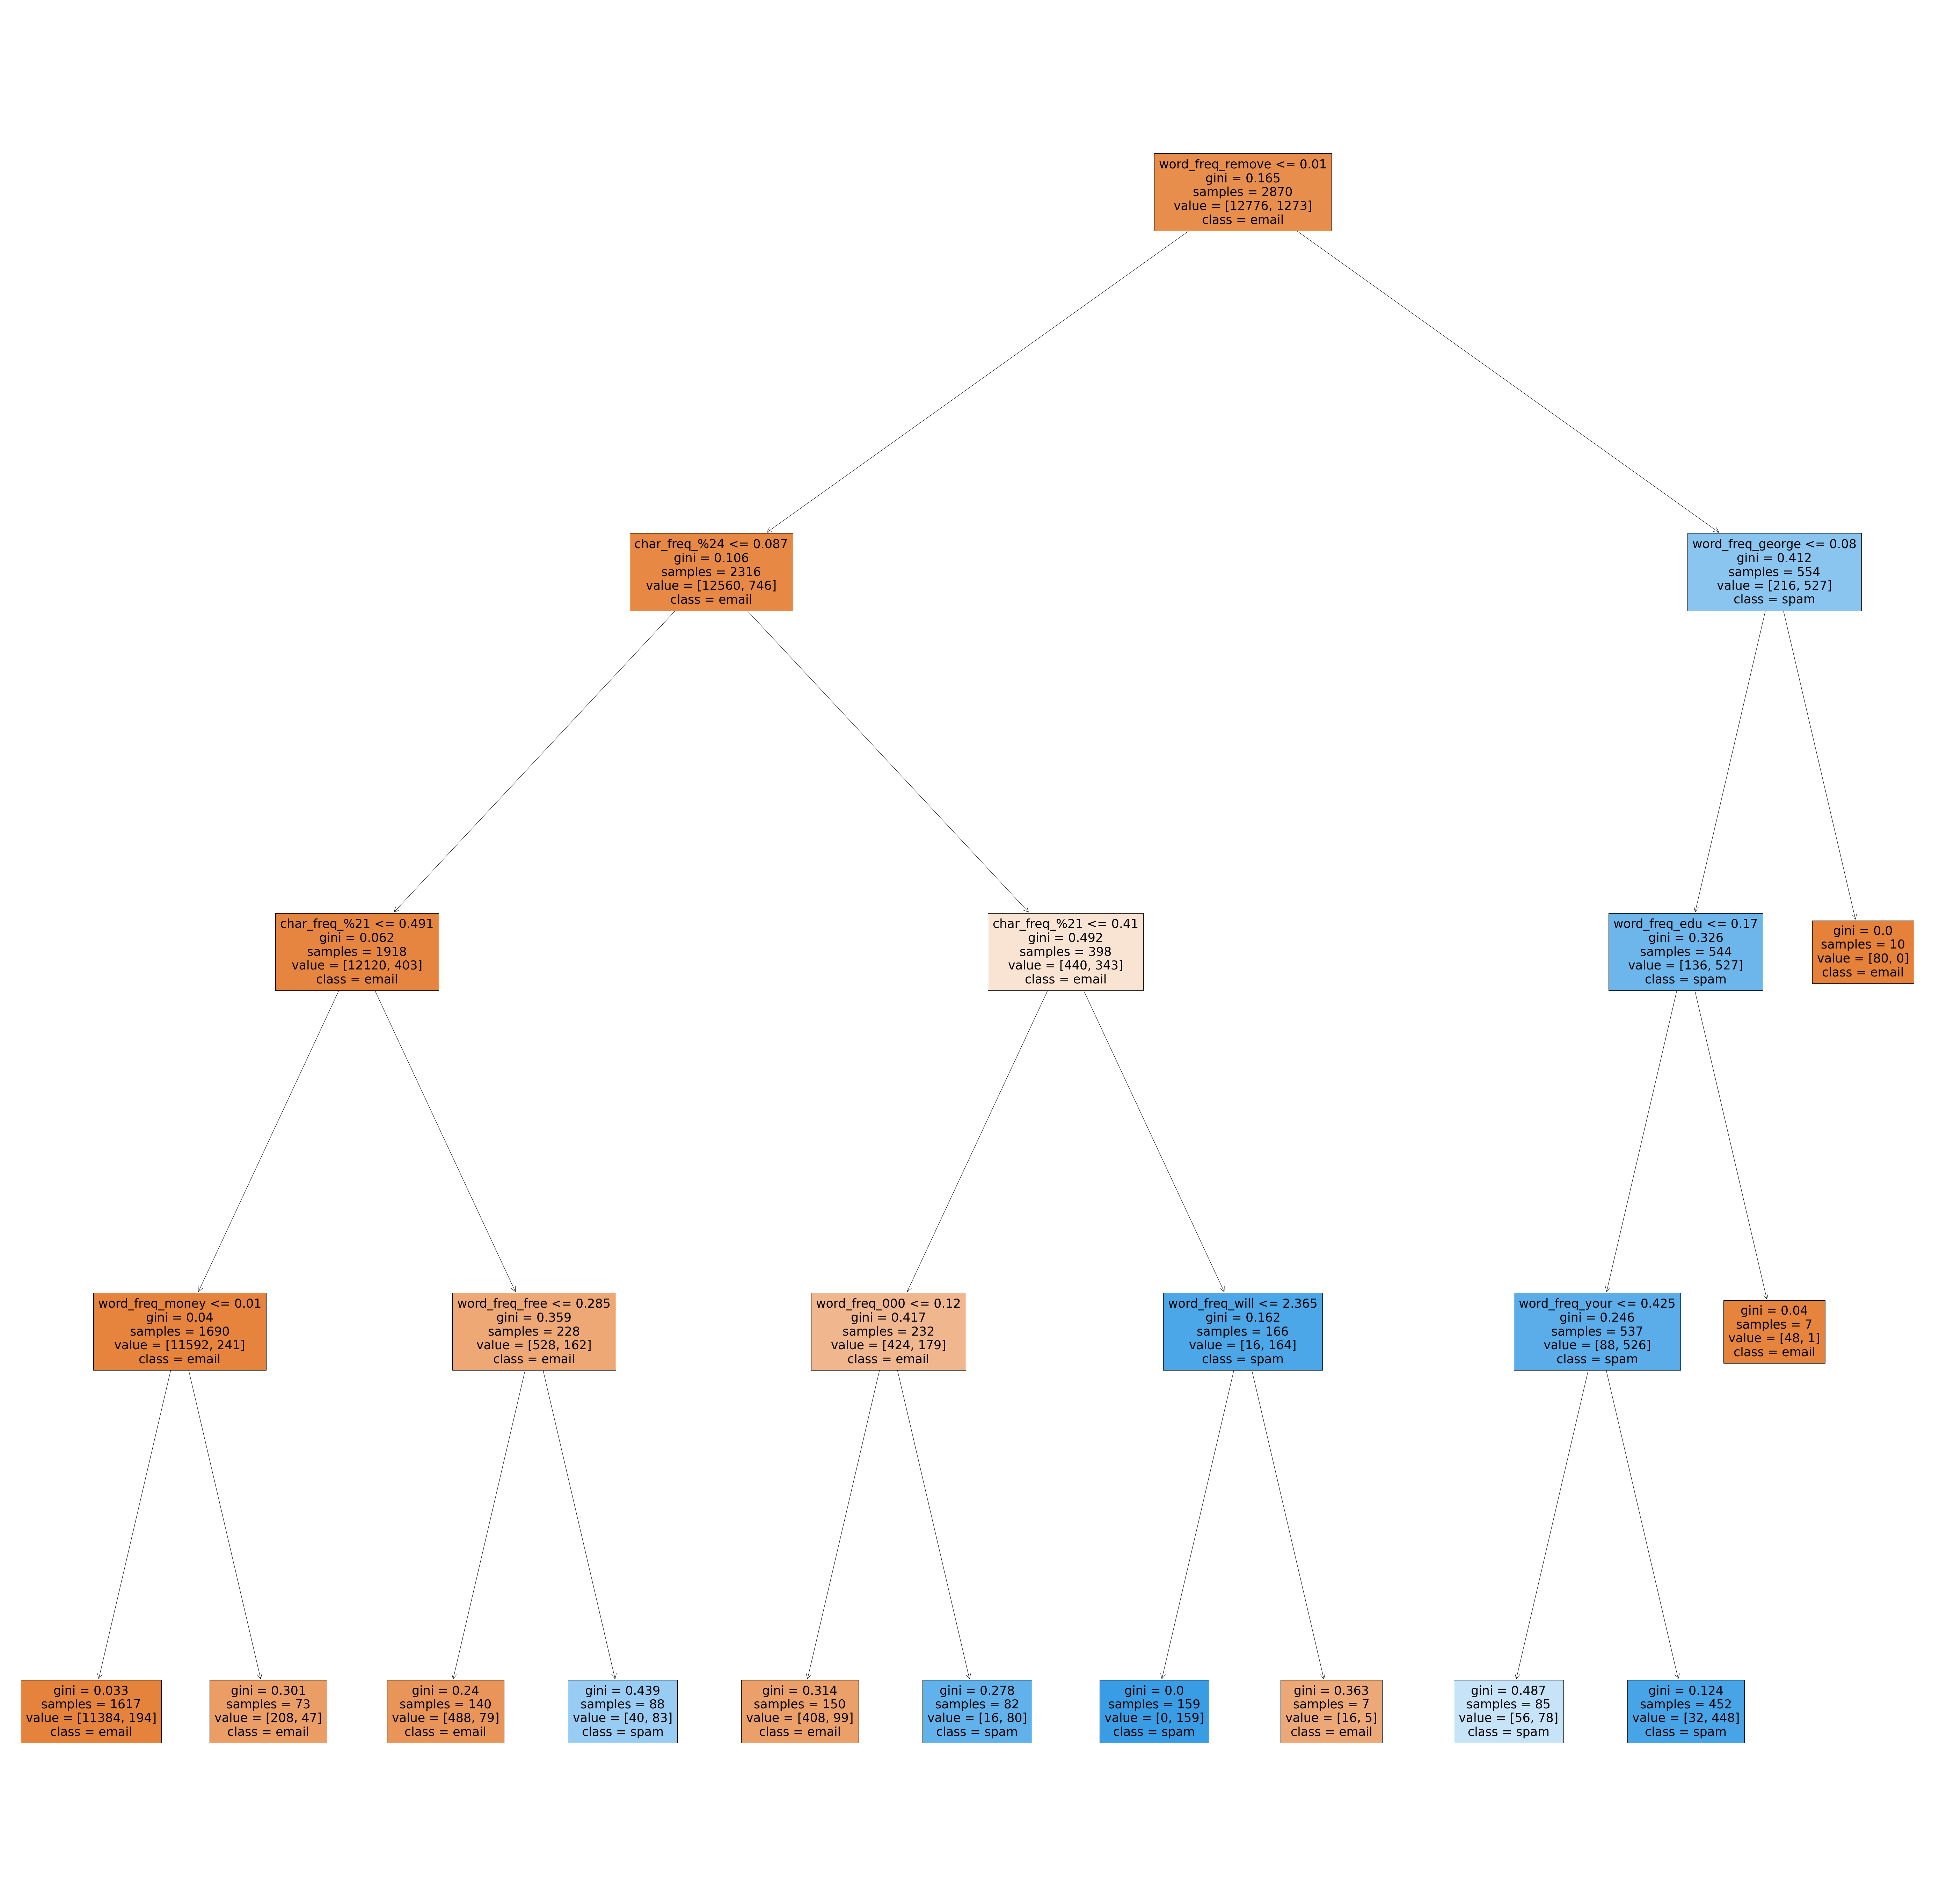

In [192]:
fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(clf.best_estimator_, 
                   feature_names=predictors,  
                   class_names=["email", "spam"],
                   filled=True)


On first look we can see that some leaf nodes are redundant and could be pruned using a post-pruning algorithm (the two left-most leaves). Overall the decision tree looks relatively simple.

In [79]:
fig.savefig("decistion_tree2.png")

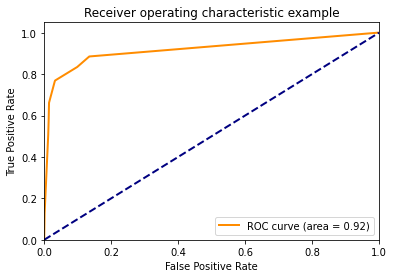

In [80]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_test_probs = clf.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()